## Bachelor's Thesis Computing Science
#### Deep Learning-based Side-Channel Attack
Beatrise Bertule (s1105119)

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import keras

import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K

### Helper Functions

In [2]:
# AES Sbox function

AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

In [3]:
# TODO: defined helper functions here

def load_data(data):
    """
    load traces, plaintexts and keys from the dataset
    
    """

    trace_idx = data.files[0]
    traces = data[trace_idx]

    plaintext_idx = data.files[1]
    plaintexts = data[plaintext_idx]

    key_idx = data.files[2]
    keys = data[key_idx]

    return traces, plaintexts, keys


def calculate_HW(data):
  """
  convert labels (sbox ouput values) to HW

  """
  hw = [bin(x).count("1") for x in range(256)]
  return [hw[int(s)] for s in data]


def prep_data(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = the leakage model of the target intermediate value

    returns a dictionary of the form
       'label_value': list of traces associated with 'label_value'
    """

    labels = np.unique(labels_set)  
    dictionary = {int(label): [] for label in labels}

    for count, label in enumerate(labels_set):
        dictionary[int(label)].append(trace_set[count])

    return dictionary


def snr_trace(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = a set of labels of the same lenght as trace_set

    returns a dictionary of the form
       'label_value': mean_sample trace with 'label_value'
    """
    mean_trace = {}
    signal_trace = []
    noise_trace = []

    labels = np.unique(labels_set) # determine the set of unique values for the leakage model - for HW, labels = {0, 1, 2, 3, 4, 5, 6, 7}, for ID, labels = {0, 1, 2,... 255}
    grouped_traces = prep_data(trace_set, labels_set) # group the traces together that share the same label

    #compute the mean trace (the same are the signal traces)
    for label in labels:                                                # for each label (HW value or ID value)
        mean_trace[label] = np.mean(grouped_traces[label], axis=0)            # calculate signal - the mean of traces that share the same label 
        signal_trace.append(mean_trace[label])                          

    #compute the noise trace
    for label in labels:                                                # for each label (HW value or ID value)
        for trace in grouped_traces[label]:                                   # for all traces with the same label (HW value)
            noise_trace.append(trace-mean_trace[label])                             # calculate noise - trace - mean

    var_noise = np.var(noise_trace, axis=0)                     # calculate var(noise)
    var_signal = np.var(signal_trace, axis=0)                   # calculate var(signal)
    snr_trace = var_signal/var_noise                            # calculate snr = var(signal)/var(noise)

    return snr_trace


def points_of_interets(snrs, nrp = 50):
    """
    return top nrp snr values

    """
    return np.argsort(snrs)[::-1][:nrp]


def score_keys(predictions, plaintext_byte, leakage_model):
    key_scores = np.zeros(256)                                 
    for k in range(256):                                        # loop over every possible key byte value k
        hypothetical_labels = AES_Sbox[plaintext_byte ^ k]                      # compute a hypothetical leakage label if the key byte were k for the known plaintext (target) byte
        if leakage_model == "HW":
            hypothetical_labels = calculate_HW(hypothetical_labels)
        
        for trace in range(predictions.shape[0]):                               # for every attack (test) trace trace
            key_scores[k] += predictions[trace, hypothetical_labels[trace]]            # accumulate the model’s probability assigned to the hypothetical label for a particular trace

    return key_scores


def guessing_entropy(predictions, plaintexts, correct_key, nb_traces, leakage_model, nb_attacks=100, eps=1e-36):
    ranks = np.zeros(nb_attacks) 
    predictions_log = np.log(predictions + eps)

    # take a random subset of traces
    for attack in range(nb_attacks):
        r = np.random.choice(
                range(predictions_log.shape[0]), nb_traces, replace=False)

        key_scores = score_keys(predictions_log[r], plaintexts[r], leakage_model)
        order_keys = np.argsort(key_scores)[::-1]
        ranks[attack] = np.where(order_keys == correct_key)[0][0]
    return np.median(ranks), np.average(ranks) 


# Functions for returning GE vector for increasing number of traces
def score_keys_convergence(predictions, plaintexts, leakage_model):
  scores_keys = np.zeros((256, predictions.shape[0]))           # scores_keys shape (256, nb_traces)
  for k in range(256):
    # Generate Hypothetical labels for a key-candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]              # hypothetical labels shape (nb_traces, )
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    # handle the 1st trace, simply return the prediction
    scores_keys[k, 0] = predictions[0, hypothetical_labels[0]]
    for trace in range(1, predictions.shape[0]):  # how scores_keys evolve as more traces are evaluated, at some point signal should exceed the noise (?)
      scores_keys[k, trace] = scores_keys[k,trace-1] + predictions[trace, hypothetical_labels[trace]]     # predictions shape (nb_traces, 256)
  return scores_keys


def guessing_entropy_convergence(predictions, plaintexts, correct_key, leakage_model, nb_traces, nb_attacks=100):
  ranks = np.zeros((nb_attacks, nb_traces))       # ranks shape (100, 1000)

  # take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):     # repeat the attack several times (100 times) with a different subset of attack traces (bootstrapping - )
    # Take random subset of traces
    r = np.random.choice(range(predictions_log.shape[0]), nb_traces, replace=False)
    # print(predictions_log[r].shape)

    key_scores = score_keys_convergence(predictions_log[r], plaintexts[r], leakage_model)  # key_socres has shape of (256, nb_traces), where nb_traces hold the accumulated probabilities
    # print(key_scores.shape)

    for n in range(nb_traces):
      order_keys = np.argsort(key_scores[:, n])[::-1]                       # (guessing vector) key_scores[:, n] returns all 256 keys but only n-th trace, shape (256, )
      # print(order_keys[1])
      ranks[attack, n]  = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks, axis=0), np.average(ranks, axis=0)                # compute the median and average rank of the correct key across all 100 attack repetitions for each trace count
  # median vector shape (nb_traces,) and average vector shape (nb_traces,) both hold convergabce rates - how the correct key's rank slowly move up the guessing vector

### Load and Explore the Dataset
Load train (profile) traces and test (attack) traces with plaintexts and fixed keys.

In [4]:
import os
os.listdir("data/CW_dataset/CW_dataset/CW_seeded")

['.DS_Store', 'ML_train', 'ML_test']

In [4]:
# load and explore the dataset

file_path_train = "data/CW_dataset/CW_dataset/CW_seeded/ML_train/device_A/dataset_device_A.npy"
data_train = np.load(file_path_train)

file_path_test = "data/CW_dataset/CW_dataset/CW_seeded/ML_test/device_A/dataset_device_A.npy"
data_test = np.load(file_path_test)

# print(data_train.files)
# print(data_test.files)

In [5]:
# load train set

traces_train, plaintexts_train, keys_train = load_data(data_train)
print(traces_train.shape)

(50000, 12000)


In [6]:
# laod test set

traces_test, plaintexts_test, keys_test = load_data(data_test)
print(traces_test.shape)

(10000, 12000)


In [5]:
# print("KEYS")
# print(X_keys_train.shape)
# print(X_keys_test.shape)
# print('\n')

# print("TEXTS")
# print(X_plaintext_train.shape)
# print(X_plaintext_test.shape)
# print('\n')

# print("TRACES")
# print(X_traces_train.shape)
# print(X_traces_test.shape)

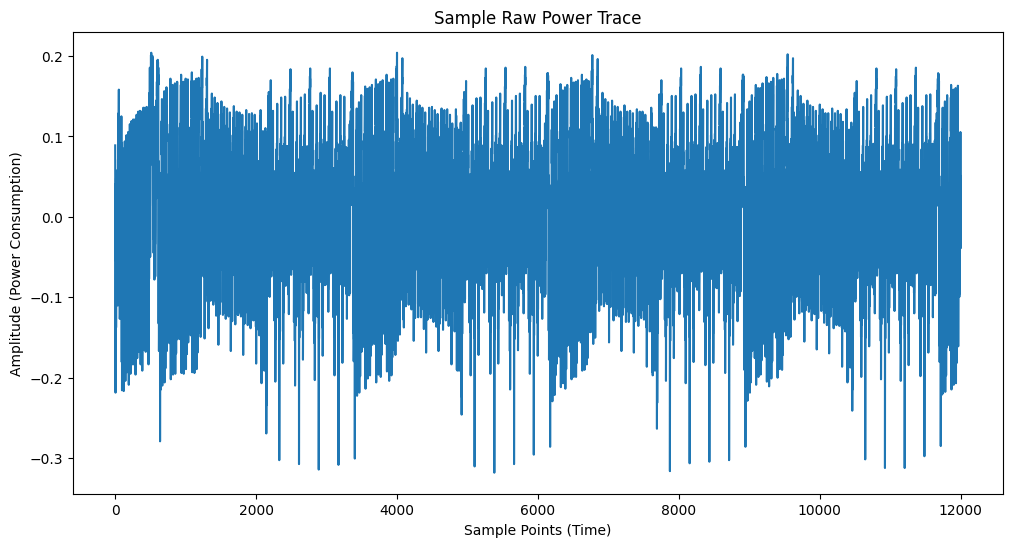

In [7]:
# visualize one trace

idx = 0

plt.figure(figsize=(12, 6))
plt.plot(traces_train[idx])
plt.title(f"Sample Raw Power Trace")
plt.xlabel("Sample Points (Time)")
plt.ylabel("Amplitude (Power Consumption)")
plt.show()

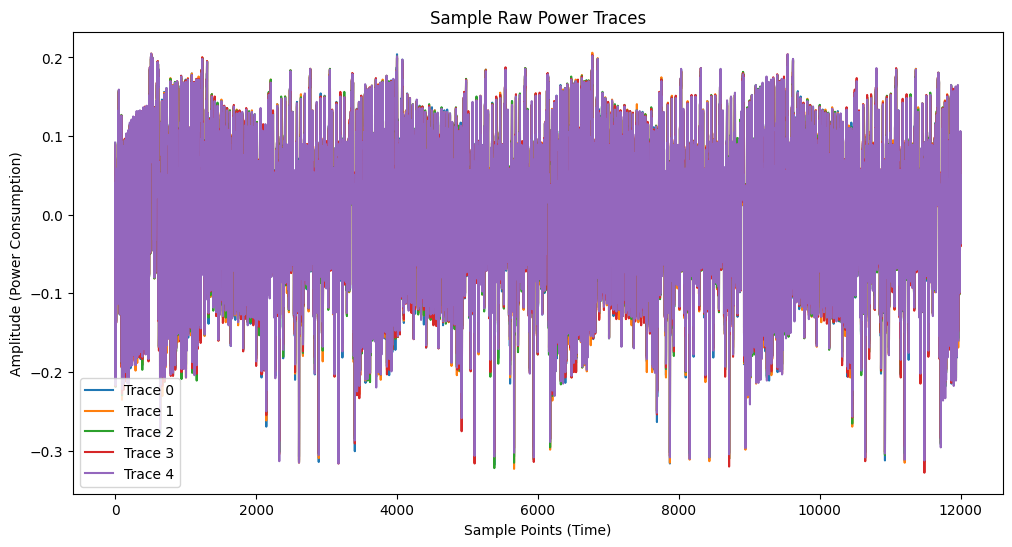

In [8]:
# visualize multiple traces

num_traces_to_plot = 5

plt.figure(figsize=(12, 6))

for i in range(num_traces_to_plot):
    plt.plot(traces_train[i], label=f"Trace {i}")

plt.title("Sample Raw Power Traces")
plt.xlabel("Sample Points (Time)")
plt.ylabel("Amplitude (Power Consumption)")
plt.legend()
plt.show()

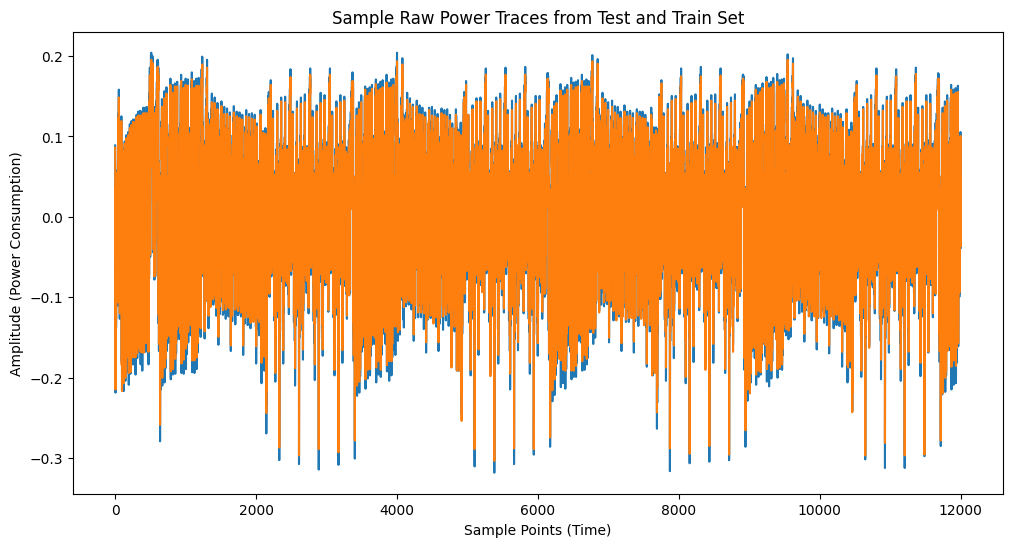

In [16]:
idx = 0

plt.figure(figsize=(12, 6))
plt.plot(traces_train[idx])
plt.plot(traces_test[idx])
plt.title(f"Sample Raw Power Traces from Test and Train Set")
plt.xlabel("Sample Points (Time)")
plt.ylabel("Amplitude (Power Consumption)")
plt.show()

### Prepare Labels

The labels will be the S-box function output values.

In [8]:
# create labels - AES-sbox(plaintext xor key) - for a particular target byte

def create_labels(ptxt_train, keys_train, ptxt_test, keys_test, target_byte = 0):
    y_train = AES_Sbox[ptxt_train[:, target_byte] ^ keys_train[:, target_byte]]
    y_test = AES_Sbox[ptxt_test[:, target_byte] ^ keys_test[:, target_byte]]
    return y_train, y_test

y_train, y_test = create_labels(plaintexts_train, keys_train, plaintexts_test, keys_test)

# print(y_train.shape)
# print(y_train[:5])

### Preprocess the Data
Standardize the raw traces and select features - perform OPOI selection with HW leakage model.

In [ ]:
# standardize the raw tarces

# scaler = StandardScaler() 
# traces_train = scaler.fit_transform(traces_train)
# traces_test = scaler.transform(traces_test)


In [ ]:
# select features on train set
# traces_train.shape = (50'000, 1200)

leakage_model = 'HW' # or 'ID' (ID gives 256 classes, HW gives 9 classes)

if leakage_model == 'HW':
  y_train = calculate_HW(y_train) 
  y_test = calculate_HW(y_test)

n = 10000 # for now I calculate the snr values based on the 1st 3000 traces, as my computer cannot compute more...
traces_train_subset = traces_train[:n]
y_train_subset = y_train[:n]

snr_values_train = snr_trace(traces_train_subset, y_train_subset)
pois_train = points_of_interets(snr_values_train)
selected_features_train = traces_train[:, pois_train]

print(traces_train_subset.shape)
print(selected_features_train.shape)

In [10]:
# select a window of traces

x = 1320
size = 50

selected_window_train = traces_train[:, x-size:x+size]
selected_window_test = traces_test[:, x-size:x+size]

# print(selected_window_train.shape)
# print(selected_window_test.shape)

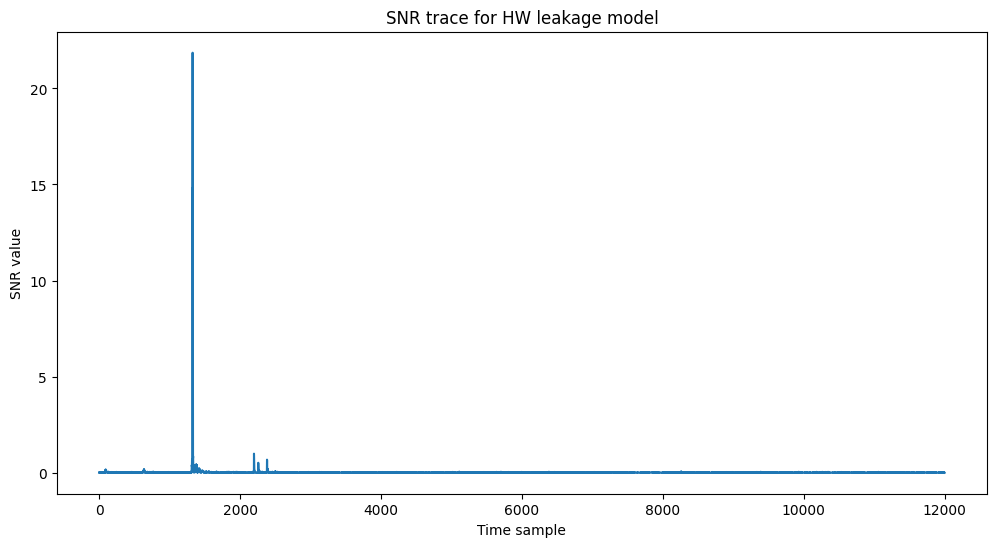

In [14]:
# plot SNR trace for HW leakage model

plt.figure(figsize=(12,6))
plt.plot(snr_values_train)
plt.title("SNR trace for HW leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.show()

# plt.savefig("snr-trace.pdf")

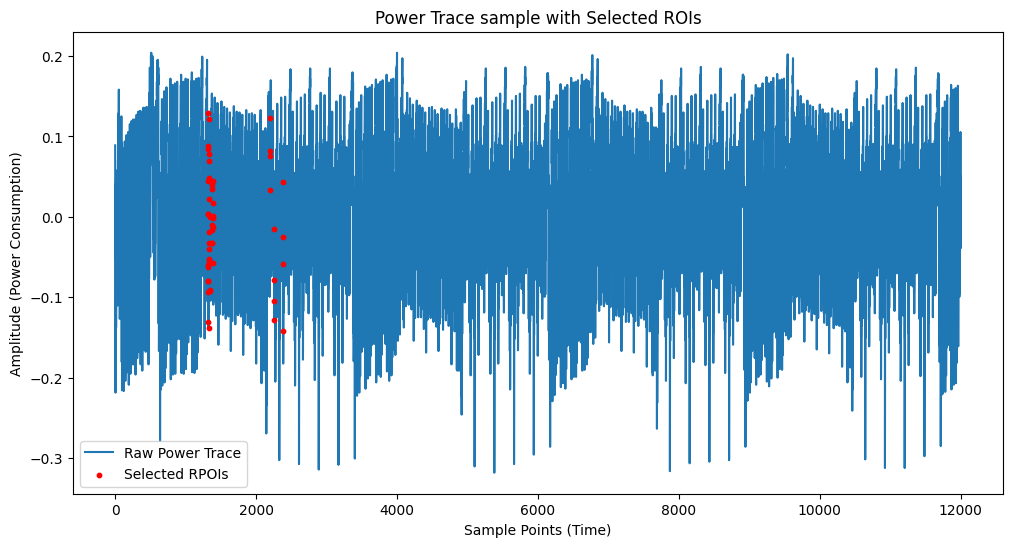

In [11]:
# plot selected POIs over a raw power traces

trace_idx = 0
trace = traces_train[trace_idx]

plt.figure(figsize=(12, 6))
plt.plot(trace, label="Raw Power Trace", zorder=1)

# Use pois_train for indices, not selected_features_train[0]
plt.scatter(pois_train, trace[pois_train],
            color="red", marker="o", s=10, label="Selected RPOIs", zorder=2)

plt.title("Power Trace sample with Selected ROIs")
plt.xlabel("Sample Points (Time)")
plt.ylabel("Amplitude (Power Consumption)")
plt.legend()
plt.show()

# plt.savefig("raw-trace-w-selected-points.pdf")

In [ ]:
# choose a leakage model for the neural netwrok, and prepare the labels

leakage_model = 'ID' # or 'HW' (ID gives 256 classes, HW gives 9 classes)

if leakage_model == 'HW':
  nb_classes = 9
elif leakage_model == 'ID':
  nb_classes = 256

# convert the labels to one-hot encodede arrays
y_train = to_categorical(y_train, num_classes=nb_classes)
y_test = to_categorical(y_test, num_classes=nb_classes)

# OPOI selection - pass a range of points
X_train = selected_window_train
X_test = selected_window_test

In [17]:
print(X_train.shape)
print(X_test.shape)

(50000, 100)
(10000, 100)


In [13]:
# standardize the raw tarces

scaler = StandardScaler() 
traces_train = scaler.fit_transform(X_train)
traces_test = scaler.transform(X_test)

### PyTorch MLP Model

In [28]:
# simple MLP model - PyTorch

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        torch.manual_seed(917539)  # for reproducibility

        self.net = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, num_classes),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


def mlp_pytorch(classes, number_of_samples):
    batch_size = 100
    model = MLP(input_dim=number_of_samples, num_classes=classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion, batch_size


In [ ]:
batch_size = 100
input_size = len(X_train[0])

# prepare the dataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64) 

# print(X_train_tensor.shape)
# print(y_train_tensor.shape)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # train setup
nb_epochs = 100
model, optimizer, criterion, batch_size = mlp_pytorch(nb_classes, input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# train loop
for epoch in range(nb_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)

        # print(outputs.shape, outputs.dtype)
        # print(batch_y.shape, batch_y.dtype)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_x.size(0)

        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)  # returns 100
        correct += (predicted == torch.argmax(batch_y, -1)).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{nb_epochs}] \t\t Loss: {epoch_loss:.4f} \t\t Accuracy: {epoch_acc:.4f}")
    # print(f"Epoch [{epoch+1}/{nb_epochs}]  Loss: {epoch_loss:.4f}")


Epoch [1/100] 	 Loss: 2.3745 	 Accuracy: 0.2729
Epoch [2/100] 	 Loss: 1.7677 	 Accuracy: 0.2740
Epoch [3/100] 	 Loss: 1.7644 	 Accuracy: 0.2739
Epoch [4/100] 	 Loss: 1.7595 	 Accuracy: 0.2745
Epoch [5/100] 	 Loss: 1.7505 	 Accuracy: 0.2756
Epoch [6/100] 	 Loss: 1.7332 	 Accuracy: 0.2789
Epoch [7/100] 	 Loss: 1.7001 	 Accuracy: 0.2900
Epoch [8/100] 	 Loss: 1.6410 	 Accuracy: 0.3234
Epoch [9/100] 	 Loss: 1.5466 	 Accuracy: 0.3954
Epoch [10/100] 	 Loss: 1.4304 	 Accuracy: 0.4526
Epoch [11/100] 	 Loss: 1.3141 	 Accuracy: 0.4929
Epoch [12/100] 	 Loss: 1.2077 	 Accuracy: 0.5303
Epoch [13/100] 	 Loss: 1.1113 	 Accuracy: 0.5646
Epoch [14/100] 	 Loss: 1.0277 	 Accuracy: 0.5954
Epoch [15/100] 	 Loss: 0.9570 	 Accuracy: 0.6243
Epoch [16/100] 	 Loss: 0.8969 	 Accuracy: 0.6518
Epoch [17/100] 	 Loss: 0.8468 	 Accuracy: 0.6712
Epoch [18/100] 	 Loss: 0.8055 	 Accuracy: 0.6862
Epoch [19/100] 	 Loss: 0.7699 	 Accuracy: 0.6984
Epoch [20/100] 	 Loss: 0.7405 	 Accuracy: 0.7084
Epoch [21/100] 	 Loss: 0.7161

In [63]:
# save the model
torch.save(model.state_dict(), 'mlp_model_pytorch.pt')

In [108]:
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size, nb_classes).to(device)
model.load_state_dict(torch.load('mlp_model_pytorch.pt'))

<All keys matched successfully>

### Attack Execution & Evaluation for Pytorch MLP Model

In [109]:
# make predictions

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = X_test_tensor.to(device)
model.to(device)

model.eval()

with torch.no_grad():
    logits = model(X_test_tensor) # raw outputs
    probs = torch.nn.functional.softmax(logits, dim=1) # convert logits to probabilities

# convert the probability distributions to a numpy array
probs = probs.cpu().numpy()

In [110]:
print(probs.shape)

(10000, 256)


In [111]:
leakage_model = "ID"
target_byte = 0

nb_traces = probs.shape[0]
correct_key = keys_test[0, target_byte] # 0 because we have a fixed key, we get the 1st element from the array

key_scores = score_keys(probs, plaintexts_test[:, target_byte], leakage_model)
order_keys = np.argsort(key_scores)[::-1]
key_rank , = np.where(order_keys == correct_key)
print(f"Key rank: {key_rank}.")

Key rank: [23].


In [97]:
leakage_model = "ID"
nb_traces = probs.shape[0]
ge_median, ge_mean = guessing_entropy(probs, plaintexts_test[:, target_byte], correct_key, nb_traces, leakage_model)

print(f"The median of GE: {ge_median}.")
print(f"The mean of GE: {ge_mean}.")

The median of GE: 2.0.
The mean of GE: 2.0.


In [115]:
leakage_model = "ID"
target_byte = 0
correct_key = keys_test[0, target_byte] # 0 because we have a fixed key, we get the 1st element from the array

medge, avgge = guessing_entropy_convergence(probs, plaintexts_test[:, target_byte], correct_key, leakage_model, nb_traces=1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")

GE of 13.9 with 936 traces.


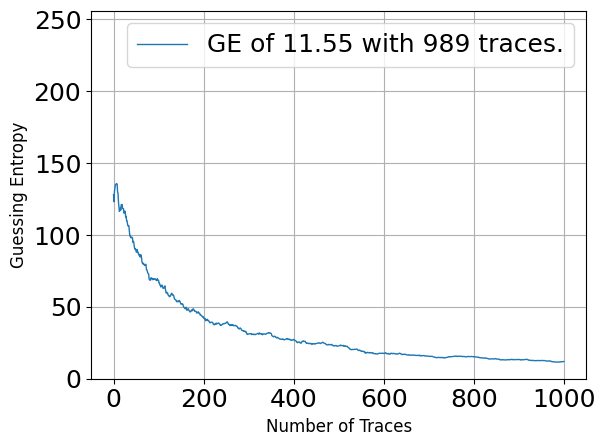

In [99]:
# plot GE convergance

figure = plt.gcf()

plt.rcParams.update({'font.size': 18})
plt.plot(avgge, linewidth=1, label=f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
plt.grid(True, which="both", ls="-")
plt.xlabel("Number of Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

### Tensorflow MLP Model

In [ ]:
# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.

def mlp_tensorflow(classes, number_of_samples):

    batch_size = 100
    tf.random.set_seed(917539)
    model = Sequential(name="mlp")
    model.add(Dense(500, activation = "relu", kernel_initializer = "he_uniform", input_shape = (number_of_samples,)))
    model.add(Dense(500, activation = "relu", kernel_initializer = "he_uniform"))
    model.add(Dense(classes, activation = "softmax"))
    model.summary()
    optimizer = Adam(learning_rate = 0.0001)
    model.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

    return model, batch_size

In [ ]:
# train the model

nb_epochs = 100
input_size = len(X_train[0])

model, batch_size = mlp_tensorflow(nb_classes, input_size)
history = model.fit(x=X_train, y=y_train, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

/home/bbertule/Documents/thesis/notebooks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-23 18:28:46.964768: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 500)            │        50,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       128,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,256 (1.64 MB)

 Trainable params: 429,256 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2691 - loss: 2.2556
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2772 - loss: 1.7528
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2871 - loss: 1.7191
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3343 - loss: 1.6492
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4152 - loss: 1.5405
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4640 - loss: 1.4188
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5011 - loss: 1.3058
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5389 - loss: 1.2056
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5715 - loss: 1.1168
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5976 - loss: 1.0385
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6205 - loss: 0.9705
Epoch 12/100
500/500 ━━━━━━━━━━━━━━━━━━━━

In [39]:
# save the model

model.save("mlp_model_tensorflow.keras")

In [79]:
# load the model

model = keras.models.load_model("mlp_model_tensorflow.keras")  # or .keras

2025-10-23 22:22:05.169049: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Attack Execution & Evaluation for Tensorflow Model

In [105]:
# make predictions
predictions = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [106]:
print(predictions.shape)a

(10000, 256)


In [116]:
leakage_model = "ID"
target_byte = 0

nb_traces = predictions.shape[0]
correct_key = keys_test[0, target_byte] # 0 because we have a fixed key, we get the 1st element from the array

key_scores = score_keys(predictions, plaintexts_test[:, target_byte], leakage_model)
order_keys = np.argsort(key_scores)[::-1]
key_rank , = np.where(order_keys == correct_key)
print(f"Key rank: {key_rank}.")

Key rank: [25].


In [102]:
leakage_model = "ID"
nb_traces = predictions.shape[0]
ge_median, ge_mean = guessing_entropy(predictions, plaintexts_test[:, target_byte], correct_key, nb_traces, leakage_model)

print(f"The median of GE: {ge_median}.")
print(f"The mean of GE: {ge_mean}.")

The median of GE: 7.0.
The mean of GE: 7.0.


In [95]:
leakage_model = "ID"
target_byte = 0
correct_key = keys_test[0, target_byte] # 0 because we have a fixed key, we get the 1st element from the array

medge, avgge = guessing_entropy_convergence(predictions, plaintexts_test[:, target_byte], correct_key, leakage_model, nb_traces=1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")

GE of 16.95 with 999 traces.


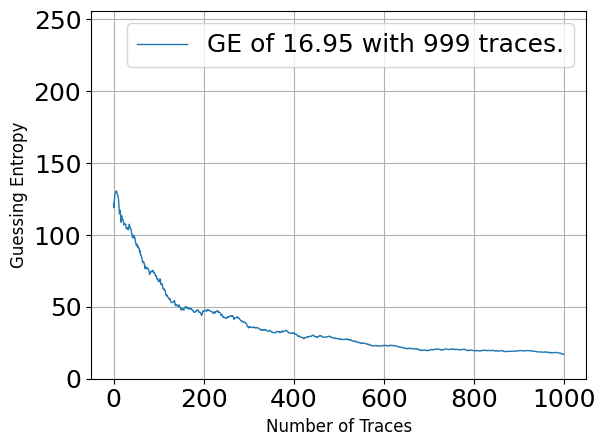

In [ ]:
# plot GE convergance
figure = plt.gcf()

plt.rcParams.update({'font.size': 18})
plt.plot(avgge, linewidth=1, label=f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
plt.grid(True, which="both", ls="-")
plt.xlabel("Number of Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()